#Anomaly Detection in Crowds using Social Force Model and OneClassSVM: Feature Extraction and Model Training

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install opencv-python opencv-python-headless numpy scikit-learn joblib -q

In [ ]:
!unzip /content/drive/MyDrive/Normal_Abnormal_Crowd.zip -d /content/dataset/

Archive:  /content/drive/MyDrive/Normal_Abnormal_Crowd.zip
   creating: /content/dataset/Normal Crowds/
  inflating: /content/dataset/Normal Crowds/341-46_l.mov  
  inflating: /content/dataset/Normal Crowds/3687-18_70.mov  
  inflating: /content/dataset/Normal Crowds/637-147_l.mov  
  inflating: /content/dataset/Normal Crowds/688-10_l.mov  
  inflating: /content/dataset/Normal Crowds/81872953_l.mov  
  inflating: /content/dataset/Normal Crowds/821-10_l.mov  
  inflating: /content/dataset/Normal Crowds/879-38_l.mov  
  inflating: /content/dataset/Normal Crowds/9019-13_l.mov  
  inflating: /content/dataset/Normal Crowds/906-17_l.mov  
  inflating: /content/dataset/Normal Crowds/CRW116.mov  
  inflating: /content/dataset/Normal Crowds/sfw20110024_l.mov  
  inflating: /content/dataset/Normal Crowds/shibuya1.mov  
   creating: /content/dataset/Abnormal Crowds/
  inflating: /content/dataset/Abnormal Crowds/1183-88_l.mov  
  inflating: /content/dataset/Abnormal Crowds/2010-291_l.avi  
  infla

##Training and Storing the model

In [ ]:
import cv2
import numpy as np
import os
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from joblib import dump

# Define the fixed length for feature vectors
FIXED_LENGTH = 1000

# Function to compute optical flow for a given video
def compute_optical_flow(video_path):
    cap = cv2.VideoCapture(video_path)
    ret, frame1 = cap.read()
    if not ret:
        print(f"Error: Could not read the first frame from {video_path}")
        return None

    prvs = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)

    flow_list = []
    frame_count = 0
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Computing optical flow for {video_path}...")

    while(cap.isOpened()):
        ret, frame2 = cap.read()
        if not ret:
            break
        next = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        flow_list.append(flow)
        prvs = next

        frame_count += 1
        if frame_count % 50 == 0:
            print(f"Processed {frame_count}/{total_frames} frames...")

    cap.release()
    print(f"Optical flow computation completed for {video_path}")
    return flow_list

# Function to compute social force from optical flow data
def compute_social_force(flow_list):
    h, w = flow_list[0].shape[:2]
    force_matrix = np.zeros((h, w, 2))
    print("Computing social forces...")

    for idx, flow in enumerate(flow_list):
        force_matrix[:, :, 0] += flow[:, :, 0]
        force_matrix[:, :, 1] += flow[:, :, 1]
        if idx % 50 == 0:
            print(f"Processed {idx+1}/{len(flow_list)} flows...")

    print("Social forces computation completed.")
    return np.sqrt(np.sum(np.square(force_matrix), axis=2))

# Function to extract features from a video
def extract_features(video_path):
    flow_list = compute_optical_flow(video_path)
    if flow_list is None:
        return None
    social_force_matrix = compute_social_force(flow_list)
    features = social_force_matrix.flatten()

    # Resize or pad the feature vector to the fixed length
    if len(features) > FIXED_LENGTH:
        features = features[:FIXED_LENGTH]
    else:
        features = np.pad(features, (0, FIXED_LENGTH - len(features)), 'constant')

    return features

# Paths to normal and abnormal video directories
normal_videos_path = '/content/dataset/Normal Crowds/'
abnormal_videos_path = '/content/dataset/Abnormal Crowds/'

# Extract features from normal videos
normal_features = []
print("Extracting features from normal videos...")
for idx, video_file in enumerate(os.listdir(normal_videos_path)):
    if video_file.endswith('.mov') or video_file.endswith('.avi'):
        video_path = os.path.join(normal_videos_path, video_file)
        features = extract_features(video_path)
        if features is not None:
            normal_features.append(features)
            print(f"Processed {idx+1}/{len(os.listdir(normal_videos_path))} videos...")
            print(f"Feature shape: {features.shape}")

# Extract features from abnormal videos
abnormal_features = []
print("Extracting features from abnormal videos...")
for idx, video_file in enumerate(os.listdir(abnormal_videos_path)):
    if video_file.endswith('.mov') or video_file.endswith('.avi'):
        video_path = os.path.join(abnormal_videos_path, video_file)
        features = extract_features(video_path)
        if features is not None:
            abnormal_features.append(features)
            print(f"Processed {idx+1}/{len(os.listdir(abnormal_videos_path))} videos...")
            print(f"Feature shape: {features.shape}")

# Standardize the features using StandardScaler
scaler = StandardScaler()
X_normal = scaler.fit_transform(normal_features)
X_abnormal = scaler.transform(abnormal_features)

# Train the OneClassSVM model with the normal features
print("Training OneClassSVM model...")
svm = OneClassSVM(kernel='rbf', gamma='auto').fit(X_normal)
print("Model training completed.")

# Save the trained model and scaler to Google Drive
model_path = '/content/drive/MyDrive/social_force_model_UCF.joblib'
scaler_path = '/content/drive/MyDrive/scaler_UCF.joblib'
dump(svm, model_path)
dump(scaler, scaler_path)

print("Model and scaler saved to Google Drive.")

Extracting features from normal videos...
Computing optical flow for /content/dataset/Normal Crowds/CRW116.mov...
Processed 50/630 frames...
Processed 100/630 frames...
Processed 150/630 frames...
Processed 200/630 frames...
Processed 250/630 frames...
Processed 300/630 frames...
Processed 350/630 frames...
Processed 400/630 frames...
Processed 450/630 frames...
Processed 500/630 frames...
Processed 550/630 frames...
Processed 600/630 frames...
Optical flow computation completed for /content/dataset/Normal Crowds/CRW116.mov
Computing social forces...
Processed 1/629 flows...
Processed 51/629 flows...
Processed 101/629 flows...
Processed 151/629 flows...
Processed 201/629 flows...
Processed 251/629 flows...
Processed 301/629 flows...
Processed 351/629 flows...
Processed 401/629 flows...
Processed 451/629 flows...
Processed 501/629 flows...
Processed 551/629 flows...
Processed 601/629 flows...
Social forces computation completed.
Processed 1/12 videos...
Feature shape: (1000,)
Computing 

##Testing the model

Computing optical flow for /content/Abnormal (4).mp4...
Processed 50/641 frames...
Processed 100/641 frames...
Processed 150/641 frames...
Processed 200/641 frames...
Processed 250/641 frames...
Processed 300/641 frames...
Processed 350/641 frames...
Processed 400/641 frames...
Processed 450/641 frames...
Processed 500/641 frames...
Processed 550/641 frames...
Processed 600/641 frames...
Optical flow computation completed for /content/Abnormal (4).mp4
Processed 50/641 frames...
Processed 100/641 frames...
Processed 150/641 frames...
Processed 200/641 frames...
Processed 250/641 frames...
Processed 300/641 frames...
Processed 350/641 frames...
Processed 400/641 frames...
Processed 450/641 frames...
Processed 500/641 frames...
Processed 550/641 frames...
Processed 600/641 frames...
Video processing completed. Output saved to /content/processed_video.avi


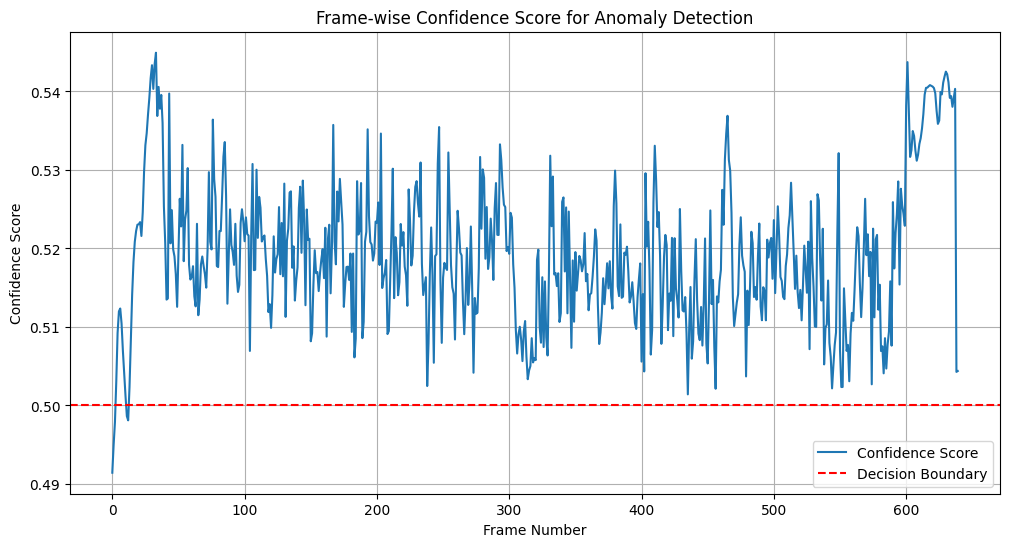

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import cv2
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from joblib import load
import os
import matplotlib.pyplot as plt

# Define the fixed length for feature vectors
FIXED_LENGTH = 1000

# Load the trained model and scaler
model_path = '/content/drive/MyDrive/social_force_model_UCF.joblib'
scaler_path = '/content/drive/MyDrive/scaler_UCF.joblib'
svm = load(model_path)
scaler = load(scaler_path)

# Compute optical flow from the video
def compute_optical_flow(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return None

    ret, frame1 = cap.read()
    if not ret:
        print(f"Error: Failed to read the first frame from {video_path}")
        cap.release()
        return None

    prvs = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    flow_list = []
    frame_count = 0
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Computing optical flow for {video_path}...")

    while cap.isOpened():
        ret, frame2 = cap.read()
        if not ret:
            break
        next = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        flow_list.append(flow)
        prvs = next

        frame_count += 1
        if frame_count % 50 == 0:
            print(f"Processed {frame_count}/{total_frames} frames...")

    cap.release()
    print(f"Optical flow computation completed for {video_path}")
    return flow_list

# Compute social forces from the optical flow
def compute_social_force(flow_list):
    h, w = flow_list[0].shape[:2]
    force_matrix = np.zeros((h, w, 2))
    print("Computing social forces...")

    for idx, flow in enumerate(flow_list):
        force_matrix[:, :, 0] += flow[:, :, 0]
        force_matrix[:, :, 1] += flow[:, :, 1]
        if idx % 50 == 0:
            print(f"Processed {idx+1}/{len(flow_list)} flows...")

    print("Social forces computation completed.")
    return np.sqrt(np.sum(np.square(force_matrix), axis=2))

# Extract features from a frame
def extract_features(frame, prvs):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prvs, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    h, w = flow.shape[:2]
    force_matrix = np.zeros((h, w, 2))

    force_matrix[:, :, 0] += flow[:, :, 0]
    force_matrix[:, :, 1] += flow[:, :, 1]

    features = np.sqrt(np.sum(np.square(force_matrix), axis=2)).flatten()

    # Resize or pad the feature vector to the fixed length
    if len(features) > FIXED_LENGTH:
        features = features[:FIXED_LENGTH]
    else:
        features = np.pad(features, (0, FIXED_LENGTH - len(features)), 'constant')

    return features

# Logistic function to convert decision scores to probabilities
def logistic_function(x):
    return 1 / (1 + np.exp(-x))

# Process the video and label anomalies
def process_video(input_video_path, output_video_path):
    if not os.path.exists(input_video_path):
        print(f"Error: Video file {input_video_path} does not exist.")
        return

    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file {input_video_path}")
        return

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    frame_count = 0
    flow_list = compute_optical_flow(input_video_path)
    if flow_list is None:
        print(f"Error: Failed to compute optical flow for {input_video_path}")
        return

    ret, frame = cap.read()
    if ret:
        prvs = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    else:
        print(f"Error: Could not read the first frame from {input_video_path}")
        cap.release()
        return

    frame_numbers = []
    confidence_scores = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Extract features from the current frame
        features = extract_features(frame, prvs)
        features = scaler.transform([features])

        # Predict using the trained model
        prediction = svm.predict(features)
        decision_score = svm.decision_function(features)[0]
        confidence_score = logistic_function(decision_score)  # Convert to range 0 to 1

        # Record frame number and confidence score
        frame_numbers.append(frame_count)
        confidence_scores.append(confidence_score)

        # Determine the label and color
        if confidence_score > 0.5:
            label = "Anomaly"
            color = (0, 0, 255)  # Red
        else:
            label = "Normal"
            color = (0, 255, 0)  # Green

        # Put the label on the frame
        cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)

        # Write the frame into the output video
        out.write(frame)

        frame_count += 1
        if frame_count % 50 == 0:
            print(f"Processed {frame_count}/{total_frames} frames...")

    cap.release()
    out.release()
    print(f"Video processing completed. Output saved to {output_video_path}")

    # Plot the confidence scores
    plt.figure(figsize=(12, 6))
    plt.plot(frame_numbers, confidence_scores, label="Confidence Score")
    plt.axhline(y=0.5, color='r', linestyle='--', label="Decision Boundary")
    plt.xlabel("Frame Number")
    plt.ylabel("Confidence Score")
    plt.title("Frame-wise Confidence Score for Anomaly Detection")
    plt.legend()
    plt.grid(True)
    plt.show()

# Process a video and label anomalies
input_video_path = '/content/Abnormal (4).mp4'
output_video_path = '/content/processed_video.avi'
process_video(input_video_path, output_video_path)

# Download the processed video
from google.colab import files
files.download(output_video_path)